# Netflix Prize Capstone Project

Predicting movie ratings using collaborative filtering on the Netflix Prize dataset.

## Setup

In [1]:
import random
random.seed(15414494)  # Advait Abrol: N15414494

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11

## Phase 1: Data Parsing & Loading

Parse the raw Netflix data files into clean DataFrames.

**Raw data format:**
- `data.txt`: Movie IDs as `N:` followed by rating lines `user_id,rating,date`
- `movieTitles.csv`: `movie_id,year,title` with trailing commas

In [2]:
def parse_ratings(filepath):
    """Parse data.txt into DataFrame with columns: movie_id, user_id, date, rating."""
    movie_ids, user_ids, ratings, dates = [], [], [], []
    current_movie = None
    
    with open(filepath, 'r') as f:
        for line in f:
            line = line.strip()
            if line.endswith(':'):
                current_movie = int(line[:-1])
            else:
                user_id, rating, date = line.split(',')
                movie_ids.append(current_movie)
                user_ids.append(int(user_id))
                ratings.append(int(rating))
                dates.append(date)
    
    return pd.DataFrame({
        'movie_id': movie_ids,
        'user_id': user_ids,
        'date': pd.to_datetime(dates),
        'rating': ratings
    })


def parse_movies(filepath):
    """Parse movieTitles.csv into DataFrame with columns: movie_id, year, title."""
    movie_ids, years, titles = [], [], []
    
    with open(filepath, 'r') as f:
        for line in f:
            parts = line.strip().split(',')
            movie_ids.append(int(parts[0]))
            years.append(int(parts[1]) if parts[1] and parts[1] != 'NULL' else None)
            titles.append(','.join(parts[2:]).rstrip(',').strip())
    
    return pd.DataFrame({
        'movie_id': movie_ids,
        'year': years,
        'title': titles
    })

In [3]:
ratings = parse_ratings('data.txt')
movies = parse_movies('movieTitles.csv')

print(f"Ratings shape: {ratings.shape}")
print(f"Movies shape: {movies.shape}")

Ratings shape: (27010225, 4)
Movies shape: (5000, 3)


## Phase 2: Exploratory Data Analysis

### Core Dataset Statistics

In [4]:
n_users = ratings['user_id'].nunique()
n_movies = ratings['movie_id'].nunique()
n_ratings = len(ratings)
sparsity = 1 - n_ratings / (n_users * n_movies)

print("=== Dataset Overview ===")
print(f"Users: {n_users:,}")
print(f"Movies: {n_movies:,}")
print(f"Ratings: {n_ratings:,}")
print(f"Date range: {ratings['date'].min().date()} to {ratings['date'].max().date()}")
print(f"\nSparsity: {100*sparsity:.2f}%")
print(f"  → Only {100*(1-sparsity):.3f}% of the user-movie matrix is filled")
print(f"  → {n_users * n_movies - n_ratings:,} missing entries")

=== Dataset Overview ===
Users: 472,542
Movies: 5,000
Ratings: 27,010,225
Date range: 1999-11-11 to 2005-12-31

Sparsity: 98.86%
  → Only 1.143% of the user-movie matrix is filled
  → 2,335,699,775 missing entries


### Rating Distribution (idea: unlikely to be normally distributed)

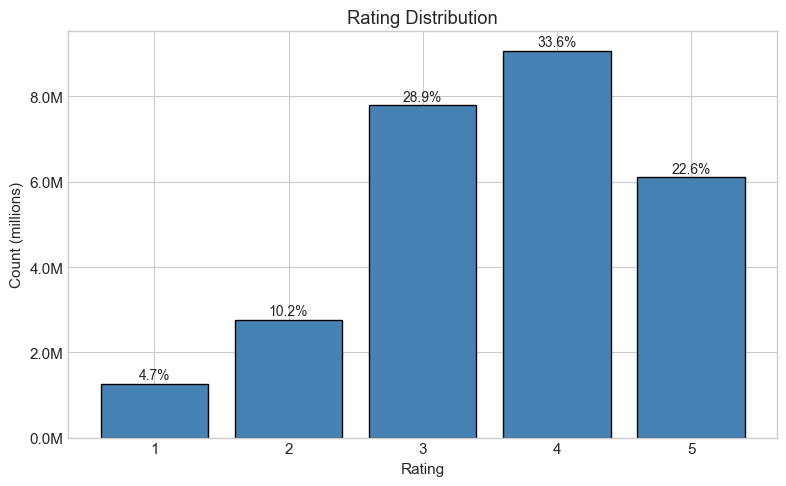


Mean: 3.59, Median: 4, Std: 1.09
Note: Distribution is left-skewed (most ratings are 3-4 stars), not normal.


In [5]:
rating_counts = ratings['rating'].value_counts().sort_index()

fig, ax = plt.subplots(figsize=(8, 5))
bars = ax.bar(rating_counts.index, rating_counts.values, color='steelblue', edgecolor='black')
ax.set_xlabel('Rating')
ax.set_ylabel('Count (millions)')
ax.set_title('Rating Distribution')
ax.set_xticks([1, 2, 3, 4, 5])
ax.yaxis.set_major_formatter(lambda x, p: f'{x/1e6:.1f}M')

# Add percentage labels on bars
for bar, count in zip(bars, rating_counts.values):
    pct = 100 * count / n_ratings
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 100000, 
            f'{pct:.1f}%', ha='center', fontsize=10)

plt.tight_layout()
plt.savefig('fig_rating_distribution.png', dpi=150)
plt.show()

print(f"\nMean: {ratings['rating'].mean():.2f}, Median: {ratings['rating'].median():.0f}, Std: {ratings['rating'].std():.2f}")
print("Note: Distribution is left-skewed (most ratings are 3-4 stars), not normal.")


### Sparsity Vizualization (idea: lots of missing data)

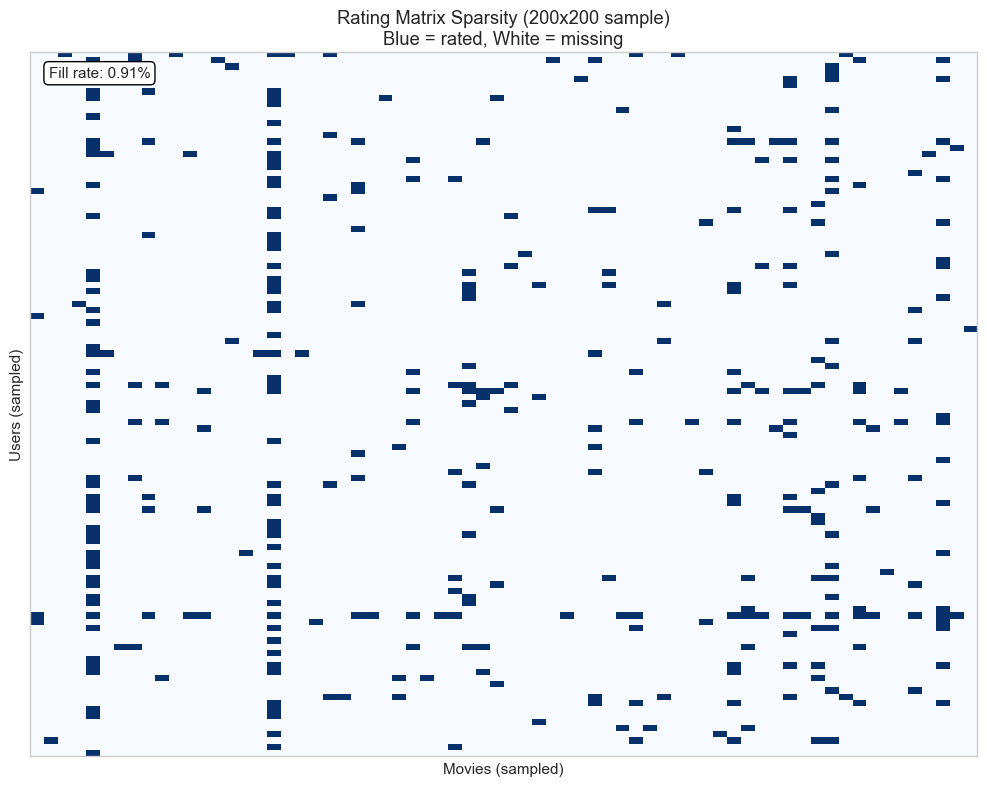

Sample fill rate: 0.91% (full dataset: 1.14%)


In [6]:
# Sample 200 users and 200 movies to create a viewable heatmap
np.random.seed(15414494)
sample_users = np.random.choice(ratings['user_id'].unique(), 200, replace=False)
sample_movies = np.random.choice(ratings['movie_id'].unique(), 200, replace=False)

sample = ratings[ratings['user_id'].isin(sample_users) & ratings['movie_id'].isin(sample_movies)]
matrix_sample = sample.pivot(index='user_id', columns='movie_id', values='rating')

fig, ax = plt.subplots(figsize=(10, 8))
ax.imshow(matrix_sample.notna().values, cmap='Blues', aspect='auto', interpolation='nearest')
ax.set_xlabel('Movies (sampled)')
ax.set_ylabel('Users (sampled)')
ax.set_title(f'Rating Matrix Sparsity (200x200 sample)\nBlue = rated, White = missing')
ax.set_xticks([])
ax.set_yticks([])

# Calculate sample fill rate
sample_fill = matrix_sample.notna().sum().sum() / (200 * 200)
ax.text(0.02, 0.98, f'Fill rate: {100*sample_fill:.2f}%', transform=ax.transAxes,
        fontsize=11, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white'))

plt.tight_layout()
plt.savefig('fig_sparsity_matrix.png', dpi=150)
plt.show()

print(f"Sample fill rate: {100*sample_fill:.2f}% (full dataset: {100*(1-sparsity):.2f}%)")


###  User/movie activity distributions (idea: cold-start challenge)

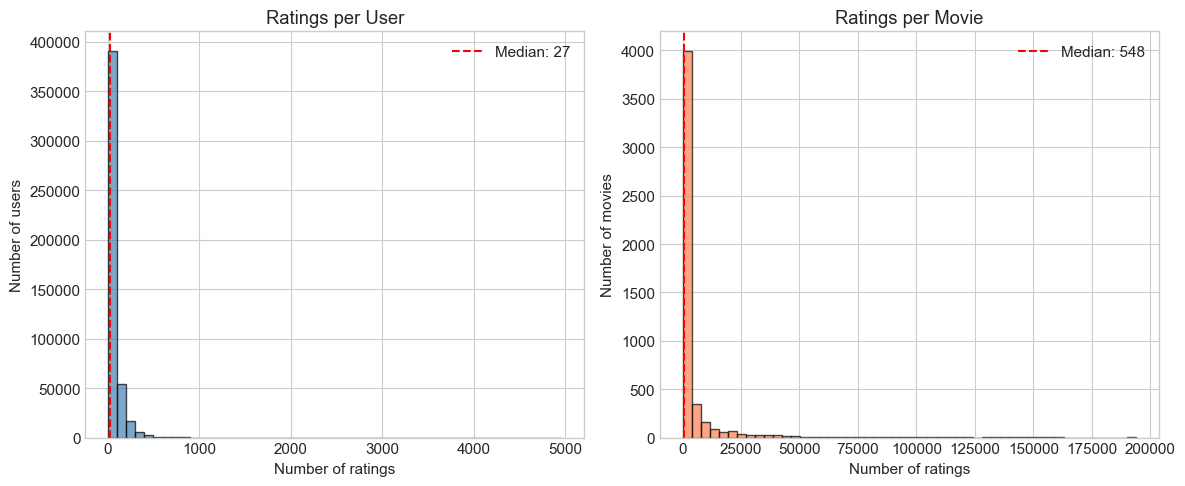

Users:  min=1, median=27, max=4,963
Movies: min=13, median=548, max=193,941


In [7]:
ratings_per_user = ratings.groupby('user_id').size()
ratings_per_movie = ratings.groupby('movie_id').size()

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Users
axes[0].hist(ratings_per_user, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Number of ratings')
axes[0].set_ylabel('Number of users')
axes[0].set_title('Ratings per User')
axes[0].axvline(ratings_per_user.median(), color='red', linestyle='--', label=f'Median: {ratings_per_user.median():.0f}')
axes[0].legend()

# Movies
axes[1].hist(ratings_per_movie, bins=50, color='coral', edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Number of ratings')
axes[1].set_ylabel('Number of movies')
axes[1].set_title('Ratings per Movie')
axes[1].axvline(ratings_per_movie.median(), color='red', linestyle='--', label=f'Median: {ratings_per_movie.median():.0f}')
axes[1].legend()

plt.tight_layout()
plt.savefig('fig_activity_distributions.png', dpi=150)
plt.show()

print(f"Users:  min={ratings_per_user.min()}, median={ratings_per_user.median():.0f}, max={ratings_per_user.max():,}")
print(f"Movies: min={ratings_per_movie.min()}, median={ratings_per_movie.median():.0f}, max={ratings_per_movie.max():,}")

###  Extra credit - Seasonal & Temporal (month/day) patterns in ratings

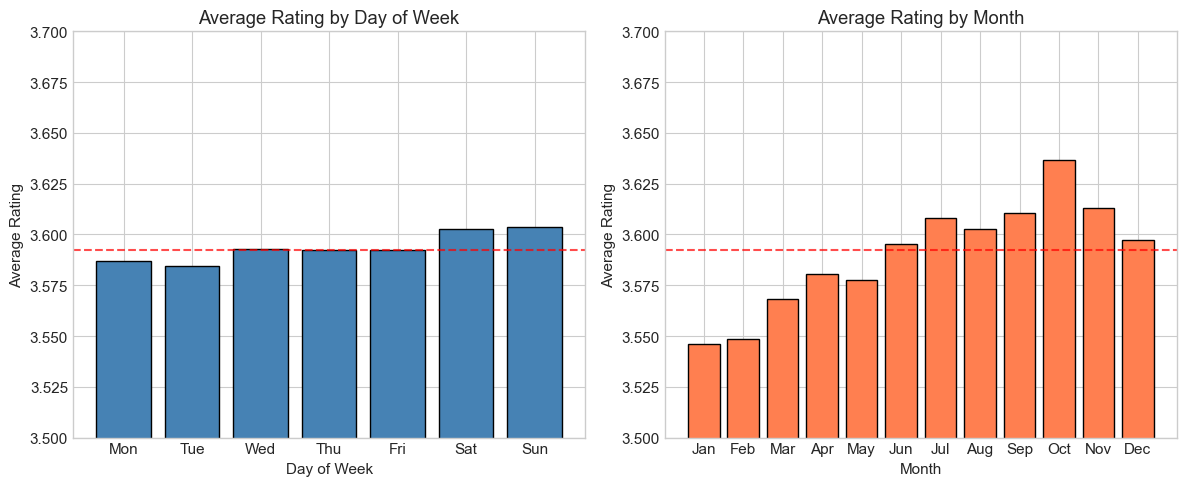

Day range: 3.584 - 3.604 (Δ = 0.020)
Month range: 3.546 - 3.637 (Δ = 0.091)


In [8]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# By day of week
day_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
ratings['dow'] = ratings['date'].dt.dayofweek
avg_by_day = ratings.groupby('dow')['rating'].mean()

axes[0].bar(day_order, avg_by_day.values, color='steelblue', edgecolor='black')
axes[0].set_xlabel('Day of Week')
axes[0].set_ylabel('Average Rating')
axes[0].set_title('Average Rating by Day of Week')
axes[0].set_ylim(3.5, 3.7)
axes[0].axhline(ratings['rating'].mean(), color='red', linestyle='--', alpha=0.7)

# By month
avg_by_month = ratings.groupby(ratings['date'].dt.month)['rating'].mean()
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

axes[1].bar(month_labels, avg_by_month.values, color='coral', edgecolor='black')
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Average Rating')
axes[1].set_title('Average Rating by Month')
axes[1].set_ylim(3.5, 3.7)
axes[1].axhline(ratings['rating'].mean(), color='red', linestyle='--', alpha=0.7)

ratings.drop('dow', axis=1, inplace=True)

plt.tight_layout()
plt.savefig('fig_seasonal_patterns.png', dpi=150)
plt.show()

print(f"Day range: {avg_by_day.min():.3f} - {avg_by_day.max():.3f} (Δ = {avg_by_day.max() - avg_by_day.min():.3f})")
print(f"Month range: {avg_by_month.min():.3f} - {avg_by_month.max():.3f} (Δ = {avg_by_month.max() - avg_by_month.min():.3f})")

### Extra credit - Movie age vs rating (uses movieTitles.csv)

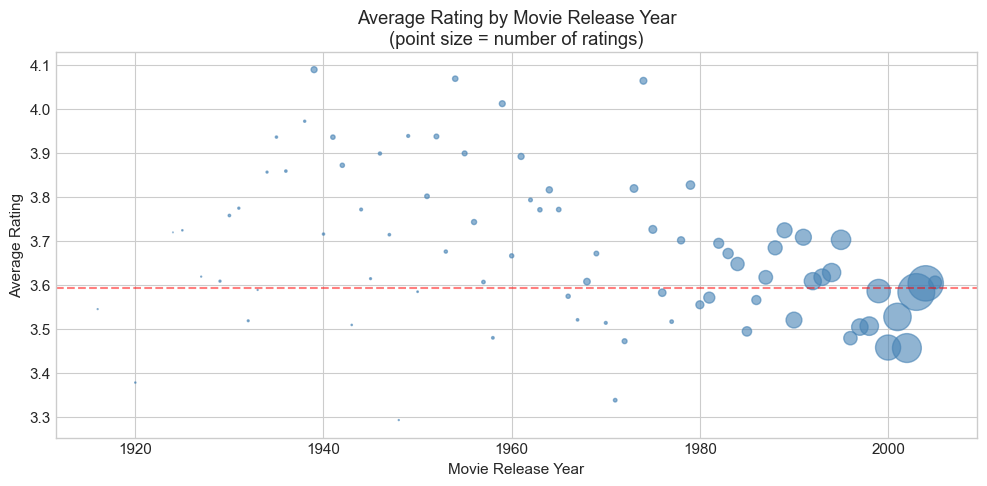

Observation: Older movies tend to have higher average ratings.
This could be survivorship bias (only 'classics' remain known) or nostalgia effects.


In [9]:
# Merge ratings with movie release year
ratings_with_year = ratings.merge(movies[['movie_id', 'year']], on='movie_id')
ratings_with_year = ratings_with_year.dropna(subset=['year'])

avg_by_year = ratings_with_year.groupby('year')['rating'].agg(['mean', 'count'])
avg_by_year = avg_by_year[avg_by_year['count'] >= 1000]  # Filter for reliability

fig, ax = plt.subplots(figsize=(10, 5))
ax.scatter(avg_by_year.index, avg_by_year['mean'], s=avg_by_year['count']/5000, alpha=0.6, color='steelblue')
ax.set_xlabel('Movie Release Year')
ax.set_ylabel('Average Rating')
ax.set_title('Average Rating by Movie Release Year\n(point size = number of ratings)')
ax.axhline(ratings['rating'].mean(), color='red', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.savefig('fig_rating_by_release_year.png', dpi=150)
plt.show()

print("Observation: Older movies tend to have higher average ratings.")
print("This could be survivorship bias (only 'classics' remain known) or nostalgia effects.")



### Data integrity check

In [10]:
print("=== Data Integrity ===")
print(f"Missing values in ratings: {ratings.isnull().sum().to_dict()}")
print(f"Rating range: {ratings['rating'].min()} to {ratings['rating'].max()} (expected 1-5)")
print(f"Movies in ratings not in titles: {len(set(ratings['movie_id']) - set(movies['movie_id']))}")
print(f"Movies in titles not in ratings: {len(set(movies['movie_id']) - set(ratings['movie_id']))}")

=== Data Integrity ===
Missing values in ratings: {'movie_id': 0, 'user_id': 0, 'date': 0, 'rating': 0}
Rating range: 1 to 5 (expected 1-5)
Movies in ratings not in titles: 0
Movies in titles not in ratings: 0


## Phase 3: Train/Test Split

Per assignment spec: Hold out one random rating per movie for the test set.

In [11]:
def train_test_split(ratings, seed):
    """
    Split ratings into train/test sets.
    Test set: one randomly selected rating per movie (5000 total).
    Train set: all remaining ratings.
    """
    np.random.seed(seed)
    
    # For each movie, randomly select one rating index for test set
    test_indices = (
        ratings.groupby('movie_id')
        .apply(lambda x: x.sample(n=1).index[0])
        .values
    )
    
    test = ratings.loc[test_indices].reset_index(drop=True)
    train = ratings.drop(test_indices).reset_index(drop=True)
    
    return train, test


# Perform split using N-number seed
train, test = train_test_split(ratings, seed=15414494)

# Verify split
print("=== Train/Test Split ===")
print(f"Train: {len(train):,} ratings")
print(f"Test:  {len(test):,} ratings (one per movie)")
print(f"Total: {len(train) + len(test):,} (matches original: {len(train) + len(test) == len(ratings)})")
print(f"\nTest set movies: {test['movie_id'].nunique()} unique (expected: 5000)")

C:\Users\Advait\AppData\Local\Temp\ipykernel_9968\1971322116.py:12: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=1).index[0])


=== Train/Test Split ===
Train: 27,005,225 ratings
Test:  5,000 ratings (one per movie)
Total: 27,010,225 (matches original: True)

Test set movies: 5000 unique (expected: 5000)


## Phase 4: Naive Baseline (Global Mean) & Baseline Model

Our baseline predicts ratings using additive bias terms:

    r̂_ui = μ + b_u + b_i

Where:
- **μ** = global mean rating (across all training data)
- **b_u** = user bias (how much user u deviates from the global mean) in their ratings
- **b_i** = movie bias (how much movie i deviates from the global mean) in its ratings

This captures two intuitive effects:
1. Some users are generous raters, others are harsh
2. Some movies are universally loved, others universally disliked

### Why not a weighted average of user_mean and movie_mean?

A weighted average like `0.5 * user_mean + 0.5 * movie_mean` double-counts the 
global mean. The additive bias formulation avoids this by centering each bias 
around zero.

### Handling edge cases

For test set predictions, we may encounter:
- Users not in training set → b_u = 0 (fall back to μ + b_i)
- Movies not in training set → b_i = 0 (fall back to μ + b_u)

In our split, every movie appears in training (we only held out ONE rating per 
movie), so b_i is always available. Users could theoretically be missing if 
they only rated one movie and that rating went to test, but this is rare.


In [12]:
#Implementation
class BiasBaseline:
    """Baseline model: global mean + user bias + movie bias."""
    
    def __init__(self):
        self.mu = None
        self.user_bias = None
        self.movie_bias = None
    
    def fit(self, train):
        """Learn biases from training data."""
        self.mu = train['rating'].mean()
        self.user_bias = train.groupby('user_id')['rating'].mean() - self.mu
        self.movie_bias = train.groupby('movie_id')['rating'].mean() - self.mu
        return self
    
    def predict(self, user_ids, movie_ids):
        """Predict ratings for user-movie pairs."""
        # Look up biases (default to 0 if unseen)
        b_u = np.array([self.user_bias.get(u, 0) for u in user_ids])
        b_i = np.array([self.movie_bias.get(m, 0) for m in movie_ids])
        
        # Predict and clip to valid range
        predictions = self.mu + b_u + b_i
        return np.clip(predictions, 1, 5)


def rmse(y_true, y_pred):
    """Calculate Root Mean Squared Error."""
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

In [13]:
# Naive Baseline (Global Mean)
naive_preds = np.full(len(test), train['rating'].mean())
naive_rmse = rmse(test['rating'].values, naive_preds)
print(f"Naive (global mean) RMSE: {naive_rmse:.4f}")

#Evaluation 
baseline = BiasBaseline().fit(train)

# Predict on test set
test_predictions = baseline.predict(test['user_id'].values, test['movie_id'].values)

# Evaluate
baseline_rmse = rmse(test['rating'].values, test_predictions)

print("=== Baseline Model ===")
print(f"Global mean (μ): {baseline.mu:.4f}")
print(f"User biases: min={baseline.user_bias.min():.2f}, max={baseline.user_bias.max():.2f}")
print(f"Movie biases: min={baseline.movie_bias.min():.2f}, max={baseline.movie_bias.max():.2f}")
print(f"\nBaseline RMSE: {baseline_rmse:.4f}")




Naive (global mean) RMSE: 1.2972
=== Baseline Model ===
Global mean (μ): 3.5924
User biases: min=-2.59, max=1.41
Movie biases: min=-2.32, max=1.08

Baseline RMSE: 1.0001


## Phase 5: SVD Model

Our primary model extends the bias baseline by learning latent factor representations for users and movies:

$$\hat{r}_{ui} = \mu + b_u + b_i + \mathbf{p}_u^T \mathbf{q}_i$$

The first three terms are identical to our baseline. The new term $\mathbf{p}_u^T \mathbf{q}_i$ captures the interaction between user *u*'s latent preference vector and movie *i*'s latent feature vector. These vectors are learned via stochastic gradient descent on the training ratings.

**Intuition:** Two users might both be generous raters (similar $b_u$), but one prefers action films while the other prefers dramas. The latent factors capture these nuanced preferences that biases alone cannot represent.

**Hyperparameters:**
- `n_factors=100`: Dimensionality of latent vectors
- `n_epochs=20`: Training iterations over the dataset
- `reg_all=0.02`: L2 regularization to prevent overfitting on sparse users/movies

We use the `surprise` library's SVD implementation, which matches the approach used by top Netflix Prize competitors.

In [14]:
# === Setup ===
from surprise import SVD, SVDpp, Dataset, Reader
from surprise.model_selection import GridSearchCV
import time

SEED = 15414494

# Build Surprise dataset from training data
reader = Reader(rating_scale=(1, 5))
train_surprise = Dataset.load_from_df(
    train[['user_id', 'movie_id', 'rating']], reader
)
trainset = train_surprise.build_full_trainset()

print(f"Training set: {trainset.n_users:,} users, {trainset.n_items:,} items, {trainset.n_ratings:,} ratings")

Training set: 472,540 users, 5,000 items, 27,005,225 ratings


In [15]:
# === Hyperparameter Tuning (Manual to avoid crashing) ===
# Tuning already completed - best params found were:
# n_factors=100, lr_all=0.005, reg_all=0.02

best_params = {'n_factors': 100, 'lr_all': 0.005, 'reg_all': 0.02}
print(f"Using best params from previous tuning: {best_params}")

# # Uncomment below to re-run tuning if needed:
# val_idx = train.groupby('movie_id').apply(lambda x: x.sample(1).index[0]).values
# val = train.loc[val_idx].reset_index(drop=True)
# train_inner = train.drop(val_idx).reset_index(drop=True)
# train_data = Dataset.load_from_df(train_inner[['user_id', 'movie_id', 'rating']], reader)
# trainset = train_data.build_full_trainset()
# 
# param_grid = [
#     {'n_factors': 50,  'lr_all': 0.005, 'reg_all': 0.1},
#     {'n_factors': 50,  'lr_all': 0.005, 'reg_all': 0.02},
#     {'n_factors': 100, 'lr_all': 0.005, 'reg_all': 0.05},
#     {'n_factors': 100, 'lr_all': 0.005, 'reg_all': 0.02},
#     {'n_factors': 150, 'lr_all': 0.005, 'reg_all': 0.02},
#     {'n_factors': 100, 'lr_all': 0.002, 'reg_all': 0.02},
#     {'n_factors': 100, 'lr_all': 0.01,  'reg_all': 0.02},
# ]
# 
# results = []
# for i, params in enumerate(param_grid):
#     print(f"Config {i+1}/{len(param_grid)}: {params}")
#     model = SVD(n_epochs=20, random_state=SEED, verbose=False, **params)
#     model.fit(trainset)
#     val_preds = [model.predict(u, m).est for u, m in zip(val['user_id'], val['movie_id'])]
#     val_rmse = rmse(val['rating'].values, np.array(val_preds))
#     results.append({**params, 'val_rmse': val_rmse})
#     print(f"  Val RMSE: {val_rmse:.4f}\n")
# 
# best_params = pd.DataFrame(results).sort_values('val_rmse').iloc[0].to_dict()
# del best_params['val_rmse']
# print(f"Best: {best_params}")

Using best params from previous tuning: {'n_factors': 100, 'lr_all': 0.005, 'reg_all': 0.02}


In [16]:
# === Train Final SVD with Best Params ===
# Retrain on FULL training data (train_inner + val)
full_train_data = Dataset.load_from_df(train[['user_id', 'movie_id', 'rating']], reader)
full_trainset = full_train_data.build_full_trainset()

svd_model = SVD(
    n_factors=best_params['n_factors'],
    n_epochs=20,
    lr_all=best_params['lr_all'],
    reg_all=best_params['reg_all'],
    random_state=SEED,
    verbose=True
)

t0 = time.time()
svd_model.fit(full_trainset)
print(f"\nTraining complete in {(time.time() - t0)/60:.1f} min")

# Evaluate on test
svd_preds = np.array([svd_model.predict(u, m).est 
                       for u, m in zip(test['user_id'], test['movie_id'])])
svd_rmse = rmse(test['rating'].values, svd_preds)

print(f"\n{'='*50}")
print(f"SVD Test RMSE: {svd_rmse:.4f}")
print(f"Improvement over baseline: {100*(baseline_rmse - svd_rmse)/baseline_rmse:.1f}%")

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19

Training complete in 3.9 min

SVD Test RMSE: 0.9455
Improvement over baseline: 5.5%


## Phase 7: Comparing Results

FINAL RESULTS
              Model     RMSE vs Baseline
Naive (Global Mean) 1.297210      -29.7%
      Bias Baseline 1.000105           —
        SVD (tuned) 0.945473       +5.5%


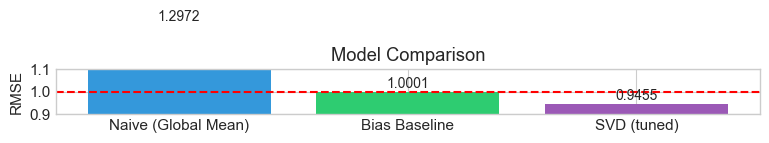

In [17]:
# === Final Results Summary ===
print("=" * 60)
print("FINAL RESULTS")
print("=" * 60)

results = pd.DataFrame({
    'Model': ['Naive (Global Mean)', 'Bias Baseline', 'SVD (tuned)'],
    'RMSE': [naive_rmse, baseline_rmse, svd_rmse],
})
results['vs Baseline'] = results['RMSE'].apply(
    lambda x: f"{100*(baseline_rmse - x)/baseline_rmse:+.1f}%" if x != baseline_rmse else "—"
)

print(results.to_string(index=False))

# Bar chart
fig, ax = plt.subplots(figsize=(8, 5))
colors = [ '#3498db', '#2ecc71', '#9b59b6']
bars = ax.bar(results['Model'], results['RMSE'], color=colors)
ax.axhline(y=baseline_rmse, color='red', linestyle='--', label='Baseline')
ax.set_ylabel('RMSE')
ax.set_title('Model Comparison')
ax.set_ylim(0.9, 1.1)
for bar, val in zip(bars, results['RMSE']):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.005, 
            f'{val:.4f}', ha='center', va='bottom', fontsize=10)
plt.tight_layout()
plt.show()